In [15]:
import numpy as np
import ddfa_node
from ddfa_node import sample_floquet_multipliers, backtrace_multipliers_all, embed_data, takens_embedding
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

# load reload extension:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
subjects = np.arange(30)
# generated_data_all = jnp.zeros((len(subjects)*10, 12000, 5))
# for idx, subject in enumerate(subjects):
#     generated_data = np.load(f"outputs/gen_vdp_data_subject_{subject}.npy")
#     plt.plot(generated_data[0, :, ::2])
#     plt.show()
#     generated_data_all = generated_data_all.at[idx*5:(idx+1)*5, :, :].set(generated_data)
# generated_data = generated_data_all

real_data = jnp.load("outputs/VDP_oscillators.npy")

data = real_data.reshape(real_data.shape[0]*real_data.shape[1], real_data.shape[2], real_data.shape[3])

window_length = 30
# Define the convolution function for a single time series
def convolve_1d(x):
    return jnp.convolve(x, jnp.ones((window_length,))/window_length, mode='valid')

# Vectorize over features
convolve_features = jax.vmap(convolve_1d, in_axes=1, out_axes=1)
# Vectorize over trials
convolve_trials = jax.vmap(convolve_features, in_axes=0, out_axes=0)

# Apply convolution to all trials and features at once
new_data = convolve_trials(data)

# Standardize the data
new_data = (new_data - jnp.mean(new_data, axis=1)[:, None, :]) / jnp.std(new_data, axis=1)[:, None, :]
τ = 26
k = 5
data_tde = takens_embedding(new_data[:, :, :1], τ, k)
generated_data = jnp.load("outputs/gen_vdp_data.npy")
print(generated_data.shape)

(300, 12000, 5)


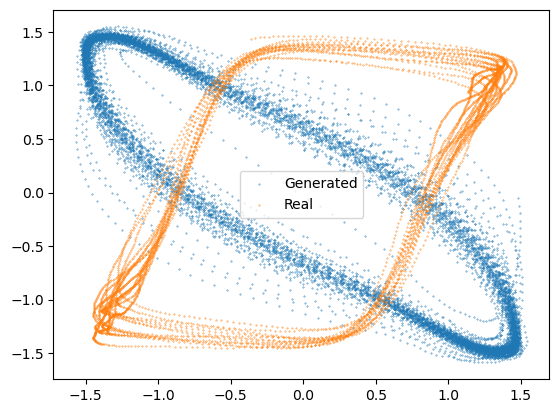

: 

In [19]:
trial = 10
plt.scatter(generated_data[trial, :, 0], generated_data[trial, :, 2], s=0.1, label="Generated")
plt.scatter(data_tde[trial, :, 0], data_tde[trial, :, 2], s=0.1, label="Real")
plt.legend()
plt.show()


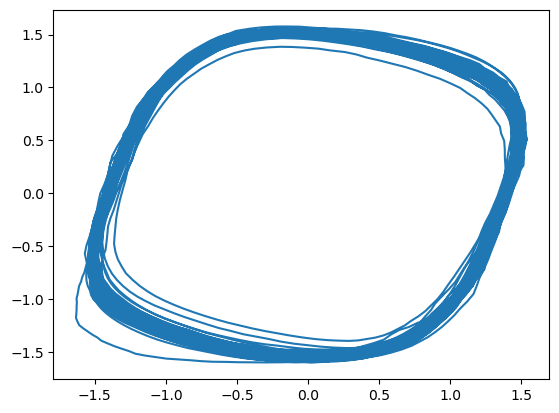

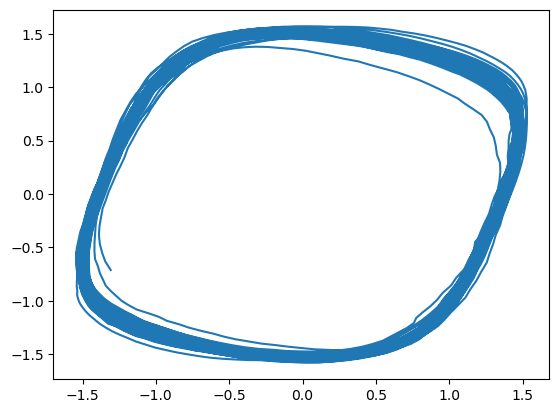

: 

In [67]:
plt.plot(generated_data[0, :, 0], generated_data[0, :, 1])
plt.show()
plt.plot(generated_data[30, :, 0], generated_data[30, :, 1])
plt.show()

In [57]:
generated_data = jnp.load("outputs/gen_vdp_data.npy")
generated_data.shape

(300, 12000, 5)

In [60]:
splits = range(2, 5)
allEigenvals, allEigenvecs, allRs, allPhis, Ns = sample_floquet_multipliers(
    generated_data[:, :, ::2],
    nSegments=20, 
    nCovReps=1, 
    phaser_feats=None, 
    splits=splits, 
    nReplicates=150, 
    usePCA=False, 
    height=0.85, 
    distance=60, 
    vecs=False)

100%|██████████| 300/300 [46:53<00:00,  9.38s/it]


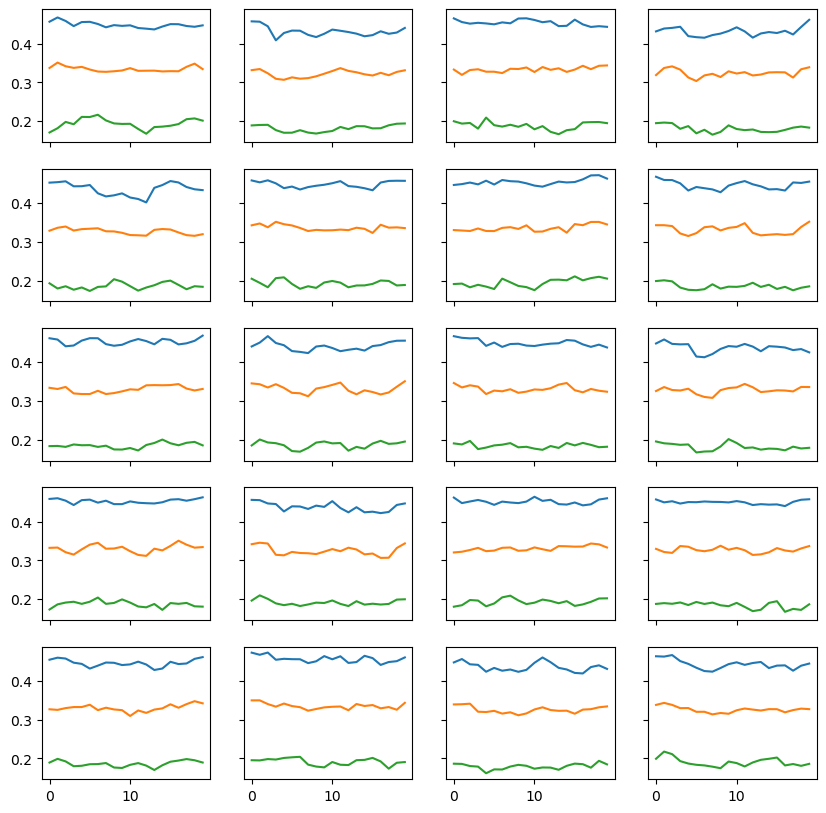

In [61]:
estimates, estimates_stderr = backtrace_multipliers_all(np.abs(allEigenvals), Ns, splits)
 
fig, axs = plt.subplots(5, 4, figsize=(10, 10), sharex=True, sharey=True)
for ii, subject in enumerate(np.linspace(0, estimates.shape[0]-1, 20).astype(int)):
    axs.ravel()[ii].plot(estimates[subject, :, :])
plt.show()


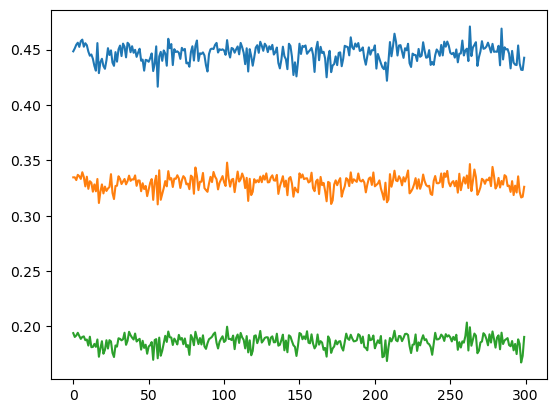

In [62]:
plt.plot(estimates[:, :, :].mean(axis=1))
plt.show()

In [ ]:
nPoints = 4
n_subjects, _, _, _, n_phases, _, n_eigs = allEigenvals.shape
estimates = np.zeros((n_subjects, n_phases, n_eigs))
estimates_stderr = np.zeros((n_subjects, n_phases, n_eigs))
for subject in range(n_subjects):
    for phase in range(n_phases):
        for eig in range(n_eigs):
            try:    
                est = backtrace_multipliers(splits, allEigenvals, Ns, subject=subject, nPoints=nPoints, phase=phase, eig=eig, plot=False, plot_title=None, ax=None)
                estimates[subject, phase, eig] = est[0]
                estimates_stderr[subject, phase, eig] = est[1]
            except:
                print(f"Error for subject {subject}, phase {phase}, eig {eig}")
plt.plot(estimates[0, 10, :])
plt.plot(estimates_stderr[0, 10, :])